In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import warnings
from tqdm import TqdmExperimentalWarning

warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.copy_on_write = True 

from traffic.core import Traffic
from datetime import timedelta

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [3]:
t = Traffic.from_file("../data/2022-01-01.parquet")
t

,count
flight_id,
248763716,29635
248763259,27916
248752988,27683
248762188,26719
248757757,26505
248751599,26222
248765179,26217
248766045,26147
248757924,25816


In [4]:
t.data = t.data.fillna(method='ffill')

# encoding

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [6]:
def encode_datetime(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [7]:
t.data['timestamp'] = pd.to_datetime(t.data['timestamp'], utc=True)
t.data['timestamp_hour'] = t.data["timestamp"].dt.hour
t.data['timestamp_minue'] = t.data["timestamp"].dt.minute
encode_datetime(t.data, 'timestamp_hour', 24)
encode_datetime(t.data, 'timestamp_minue', 60)

,flight_id,timestamp,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,v_component_of_wind,temperature,specific_humidity,timestamp_hour,timestamp_minue,timestamp_hour_sin,timestamp_hour_cos,timestamp_minue_sin,timestamp_minue_cos
0,248763775,2022-01-01 18:14:38+00:00,30.898407,31.240270,38000.0,429.0,350.888643,-64.0,248763775,8.754636,-13.070078,221.819618,0.000008,18,14,-1.000000,-1.836970e-16,0.994522,0.104528
1,248763775,2022-01-01 18:14:39+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.696749,-13.106524,221.794782,0.000008,18,14,-1.000000,-1.836970e-16,0.994522,0.104528
2,248763775,2022-01-01 18:14:40+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697087,-13.107184,221.794700,0.000008,18,14,-1.000000,-1.836970e-16,0.994522,0.104528
3,248763775,2022-01-01 18:14:41+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697424,-13.107845,221.794618,0.000008,18,14,-1.000000,-1.836970e-16,0.994522,0.104528
4,248763775,2022-01-01 18:14:42+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697762,-13.108505,221.794536,0.000008,18,14,-1.000000,-1.836970e-16,0.994522,0.104528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11862458,248772010,2022-01-02 01:59:55+00:00,44.065750,-58.601074,40975.0,543.0,76.040526,-64.0,248772010,49.665934,-31.158741,210.208665,0.000013,1,59,0.258819,9.659258e-01,-0.104528,0.994522
11862459,248772010,2022-01-02 01:59:56+00:00,44.065750,-58.601074,40975.0,543.0,76.040526,-64.0,248772010,49.665919,-31.158539,210.208654,0.000013,1,59,0.258819,9.659258e-01,-0.104528,0.994522
11862460,248772010,2022-01-02 01:59:57+00:00,44.065750,-58.601074,40975.0,543.0,76.040526,-64.0,248772010,49.665905,-31.158336,210.208643,0.000013,1,59,0.258819,9.659258e-01,-0.104528,0.994522
11862461,248772010,2022-01-02 01:59:58+00:00,44.065750,-58.601074,40975.0,543.0,76.040526,-64.0,248772010,49.665890,-31.158134,210.208632,0.000013,1,59,0.258819,9.659258e-01,-0.104528,0.994522


In [8]:
le.fit(t.data['icao24'])
t.data['icao24_category'] = le.transform(t.data['icao24']) + 1

wind angle=arctan(u_wind,v_wind)

In [9]:
# Feature Engineering
# Wind speed
t.data['wind_speed'] = np.sqrt(t.data['u_component_of_wind']**2 + t.data['v_component_of_wind'] ** 2)
t.data['wind_direction'] = np.arctan2(t.data['v_component_of_wind'], t.data['u_component_of_wind'])

# Filter for climb phase based on vertical rate (positive = climbing)
t.data = t.data[t.data['vertical_rate'] > 0]

# Prepare your features and target variable (mass prediction)
# We'll assume mass is a target column for now
features = ['altitude', 'groundspeed', 'vertical_rate', 'wind_speed','wind_direction', 'temperature', 'specific_humidity',
            'timestamp_hour_sin', 'timestamp_hour_cos','timestamp_minue_sin','timestamp_minue_cos']
X = t.data[features]
y = t.data['vertical_rate']

## Model

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set: 2095303, number of used features: 11
[LightGBM] [Info] Start training from score 1122.169225


In [12]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set: 2095303, number of used features: 11
[LightGBM] [Info] Start training from score 1122.169225


In [13]:
# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Feature importance
importances = model.feature_importances_
for feature, importance in zip(features, importances):
    print(f"{feature}: {importance:.4f}")

Root Mean Squared Error (RMSE): 15.214975207292792
altitude: 248.0000
groundspeed: 127.0000
vertical_rate: 1872.0000
wind_speed: 109.0000
wind_direction: 143.0000
temperature: 121.0000
specific_humidity: 153.0000
timestamp_hour_sin: 38.0000
timestamp_hour_cos: 22.0000
timestamp_minue_sin: 129.0000
timestamp_minue_cos: 38.0000


In [14]:
t.data['climb_efficiency'] = t.data['vertical_rate'] / t.data['groundspeed']

In [15]:
t.data[t.data['flight_id'] == 248763775]

,flight_id,timestamp,latitude,longitude,altitude,groundspeed,track,vertical_rate,icao24,u_component_of_wind,...,timestamp_hour,timestamp_minue,timestamp_hour_sin,timestamp_hour_cos,timestamp_minue_sin,timestamp_minue_cos,icao24_category,wind_speed,wind_direction,climb_efficiency
1,248763775,2022-01-01 18:14:39+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.696749,...,18,14,-1.000000,-1.836970e-16,0.994522,0.104528,1447,15.729412,-0.984959,0.298368
2,248763775,2022-01-01 18:14:40+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697087,...,18,14,-1.000000,-1.836970e-16,0.994522,0.104528,1447,15.730149,-0.984964,0.298368
3,248763775,2022-01-01 18:14:41+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697424,...,18,14,-1.000000,-1.836970e-16,0.994522,0.104528,1447,15.730886,-0.984970,0.298368
4,248763775,2022-01-01 18:14:42+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.697762,...,18,14,-1.000000,-1.836970e-16,0.994522,0.104528,1447,15.731623,-0.984975,0.298368
5,248763775,2022-01-01 18:14:43+00:00,30.909615,31.238251,38000.0,429.0,351.020434,128.0,248763775,8.698100,...,18,14,-1.000000,-1.836970e-16,0.994522,0.104528,1447,15.732360,-0.984980,0.298368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6081,248763775,2022-01-01 19:59:55+00:00,41.468733,28.752626,3525.0,237.0,193.392498,64.0,248763775,2.855464,...,19,59,-0.965926,2.588190e-01,-0.104528,0.994522,1447,8.826325,-1.241353,0.270042
6082,248763775,2022-01-01 19:59:56+00:00,41.468733,28.752626,3525.0,237.0,193.392498,64.0,248763775,2.855515,...,19,59,-0.965926,2.588190e-01,-0.104528,0.994522,1447,8.826312,-1.241346,0.270042
6083,248763775,2022-01-01 19:59:57+00:00,41.468733,28.752626,3525.0,237.0,193.392498,64.0,248763775,2.855565,...,19,59,-0.965926,2.588190e-01,-0.104528,0.994522,1447,8.826299,-1.241339,0.270042
6084,248763775,2022-01-01 19:59:58+00:00,41.468733,28.752626,3525.0,237.0,193.392498,64.0,248763775,2.855616,...,19,59,-0.965926,2.588190e-01,-0.104528,0.994522,1447,8.826286,-1.241333,0.270042


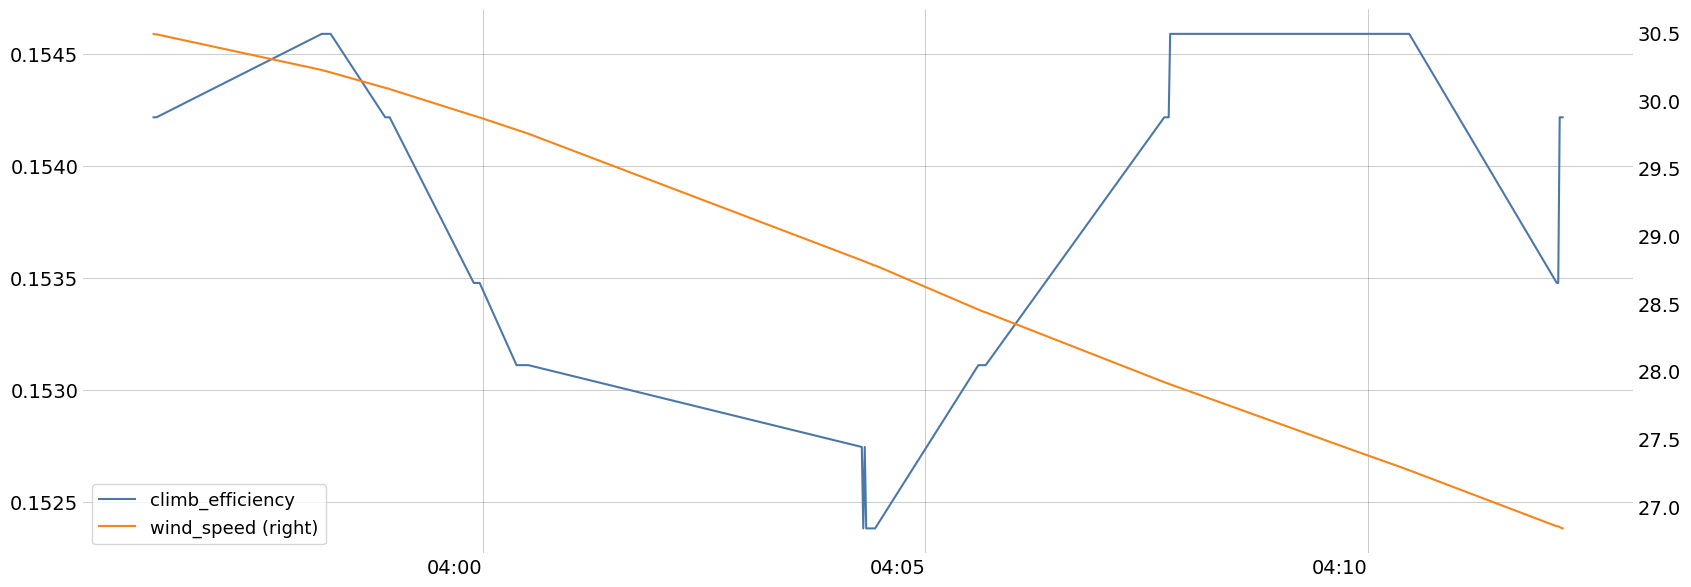

In [35]:
trj = t[1]

with plt.style.context("traffic"):

    fig, ax = plt.subplots(figsize=(20, 8))

    (
        trj
        .plot_time(
            ax=ax,
            y=["climb_efficiency", "wind_speed"],
            secondary_y=["wind_speed"]
        )
    )

    ax.set_xlabel("")
    ax.tick_params(axis='x', labelrotation=0)
    ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))